In [ ]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

path = kagglehub.dataset_download("blastchar/telco-customer-churn")
DATA_PATH = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
RANDOM_STATE = 42

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


In [ ]:
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

X = df.drop(columns=['Churn'])
y = df['Churn']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])
cat_pipe = Pipeline([('impute', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)])
preproc = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

X_train_prep = preproc.fit_transform(X_train)
X_test_prep = preproc.transform(X_test)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_prep, y_train)

clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_res, y_res)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
y_pred = clf.predict(X_test_prep)
y_proba = clf.predict_proba(X_test_prep)[:,1]

print(y_pred)
print(y_proba)

[0 1 0 ... 0 0 0]
[0.    0.69  0.06  ... 0.17  0.075 0.005]


Classification Report:


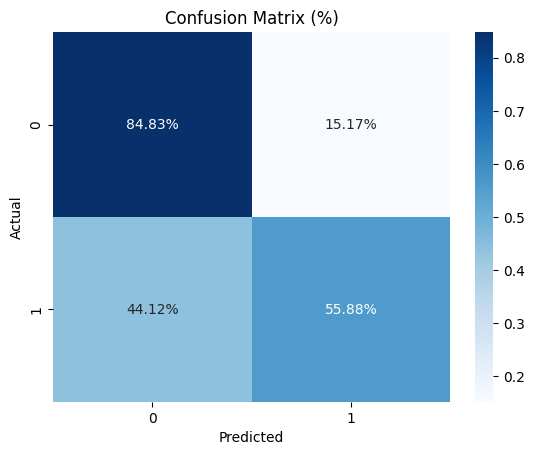

In [ ]:
print("Classification Report:")
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()


ROC Curve + AUC with Thresholds


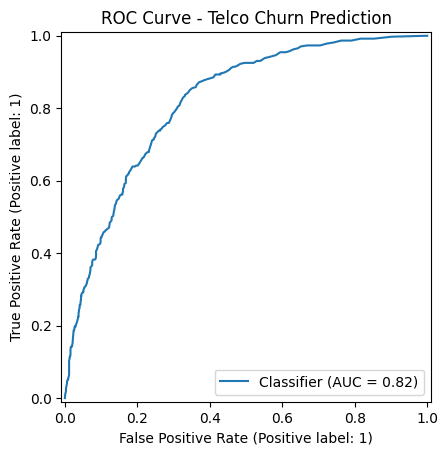

In [ ]:
print("ROC Curve + AUC with Thresholds")
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Telco Churn Prediction")
plt.show()


Precision-Recall Curve


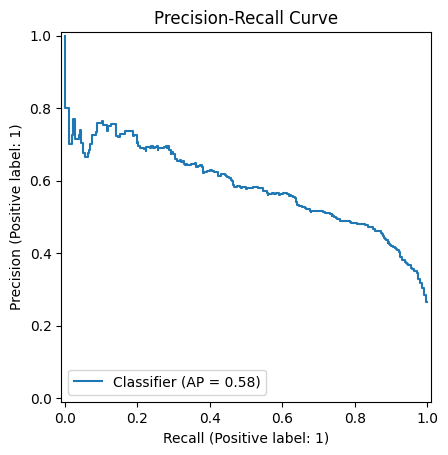

In [ ]:
print("Precision-Recall Curve")
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve")
plt.show()


Feature Importance


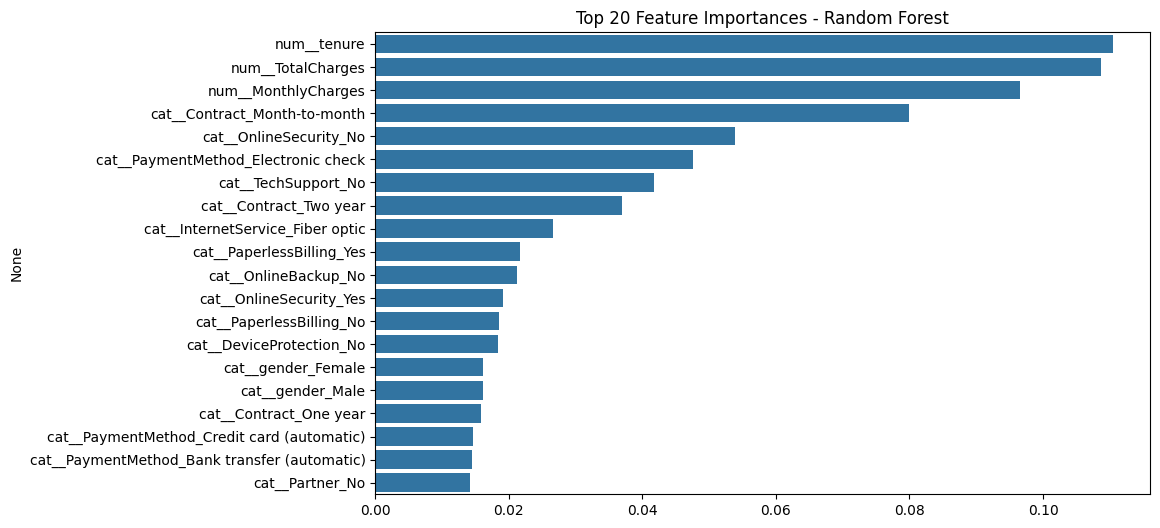

In [ ]:
print("Feature Importance")
importances = clf.feature_importances_
feature_names = preproc.get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()


In [ ]:
print("Classification Metrics by Threshold")
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.3, 0.5, 0.7]
for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    print(f"Threshold: {t}")
    print("Precision:", precision_score(y_test, y_pred_thresh))
    print("Recall:", recall_score(y_test, y_pred_thresh))
    print("F1-score:", f1_score(y_test, y_pred_thresh))
    print("-"*30)

Classification Metrics by Threshold
Threshold: 0.3
Precision: 0.48881239242685026
Recall: 0.7593582887700535
F1-score: 0.5947643979057592
------------------------------
Threshold: 0.5
Precision: 0.5660377358490566
Recall: 0.5614973262032086
F1-score: 0.5637583892617449
------------------------------
Threshold: 0.7
Precision: 0.6456310679611651
Recall: 0.35561497326203206
F1-score: 0.4586206896551724
------------------------------
